In [12]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_machine_learning.neural_networks import EstimatorQNN, EffectiveDimension
from qiskit_machine_learning.connectors import TorchConnector
import torch

def build_qnn(n_qubits) : 
    feature_map = ZZFeatureMap(feature_dimension=n_qubits, reps=1)
    ansatz = RealAmplitudes(num_qubits=n_qubits, reps=1)
    qc = QuantumCircuit(n_qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    obs = [SparsePauliOp(Pauli('Z' + 'I' * (n_qubits - 1)))]

    qnn = EstimatorQNN(
        circuit = qc,
        input_params = feature_map.parameters,
        weight_params = ansatz.parameters,
        estimator = Estimator(),
    )
    return qnn, qnn.num_weights

def compute_log_probs_grads(qnn, X, theta_np) : 
    init_theta = torch.tensor(theta_np, dtype=torch.float32)
    torch_qnn = TorchConnector(qnn, initial_weights=init_theta)

    grads = []
    for x in X : 
        x_t = torch.tensor(x, dtype=torch.float32)
        probs = torch_qnn(x_t)
        p0 = probs[0].clamp(min=1e-8)
        logp0 = torch.log(p0)
        
        grad_w, = torch.autograd.grad(
            logp0,
            torch_qnn._weights,                     # ← weight parameter
            retain_graph=False,
            allow_unused=False
        )
        grads.append(grad_w.detach().cpu().numpy())
    return np.vstack(grads)

def fisher_eigenvalues(grads) : 
    fim = grads.T @ grads / grads.shape[0]
    eigs = np.linalg.eigvals(fim)
    return np.sort(eigs)[::-1]

if __name__ == '__main__' : 
    sample_size = 750
    results = []

    for n_qubits in [3, 8, 13] : 
        print(f'\n>>> {n_qubits} qubits')
        qnn, num_params = build_qnn(n_qubits)

        X = np.random.uniform(0, 1, size=(sample_size, n_qubits))
        theta0 = np.random.uniform(-np.pi, np.pi, size=(num_params, ))

        grads = compute_log_probs_grads(qnn, X, theta0)

        eigvals = fisher_eigenvalues(grads)
        print('Fisher eigenvalues:', eigvals)

        ed_calc = EffectiveDimension(
            qnn=qnn,
            weight_samples=num_params,
            input_samples=n_qubits
        )
        ed = ed_calc.get_effective_dimension(dataset_size=sample_size)
        print(f'number of weights = {num_params}, ED = {ed:.4f}, normalized = {ed / num_params:.4f}')

        results.append({
            'n_qubits': n_qubits,
            'fisher_eigvals': eigvals,
            'ED': ed,
            'normalized_ED': ed / num_params
        })        


>>> 3 qubits


/var/folders/4h/nkpffcmn54v3c7rkqc6jvw9h0000gn/T/ipykernel_17321/3636718277.py:23: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator(),
/var/folders/4h/nkpffcmn54v3c7rkqc6jvw9h0000gn/T/ipykernel_17321/3636718277.py:19: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


Fisher eigenvalues: [206.39801   114.04485    34.22276    17.666111    7.244274    3.4467459]
number of weights = 6, ED = 3.4508, normalized = 0.5751

>>> 8 qubits


/var/folders/4h/nkpffcmn54v3c7rkqc6jvw9h0000gn/T/ipykernel_17321/3636718277.py:23: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator(),
/var/folders/4h/nkpffcmn54v3c7rkqc6jvw9h0000gn/T/ipykernel_17321/3636718277.py:19: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/qiskit_machine_learning/connectors/torch_connector.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or 

Fisher eigenvalues: [1.1443823e+04 5.1942090e+03 5.7324377e+02 3.4669366e+02 2.3619130e+02
 1.1301717e+02 4.7729912e+01 4.4612381e+01 3.3025246e+01 1.2374118e+01
 8.9581299e+00 8.7837934e+00 4.5940609e+00 3.6039090e+00 3.0151920e+00
 2.7549657e-01]
number of weights = 16, ED = 9.1378, normalized = 0.5711

>>> 13 qubits


/var/folders/4h/nkpffcmn54v3c7rkqc6jvw9h0000gn/T/ipykernel_17321/3636718277.py:23: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator(),
/var/folders/4h/nkpffcmn54v3c7rkqc6jvw9h0000gn/T/ipykernel_17321/3636718277.py:19: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/qiskit_machine_learning/connectors/torch_connector.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or 

Fisher eigenvalues: [6.6793633e+03 3.6994839e+02 1.8834355e+02 1.2902469e+02 9.2506264e+01
 5.6303738e+01 2.4406281e+01 1.9865885e+01 1.4158094e+01 1.2537500e+01
 1.1298227e+01 9.3017406e+00 8.8279896e+00 7.0327454e+00 5.3158240e+00
 4.9657722e+00 4.2007389e+00 3.9025450e+00 3.3010087e+00 2.9713738e+00
 2.6483183e+00 2.0611336e+00 1.8994069e+00 1.5669173e+00 1.2830117e+00
 1.1065853e+00]
number of weights = 26, ED = 14.7967, normalized = 0.5691


/var/folders/4h/nkpffcmn54v3c7rkqc6jvw9h0000gn/T/ipykernel_17321/219378338.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(eigenvalue_lists, labels=qubit_labels, showfliers=False)


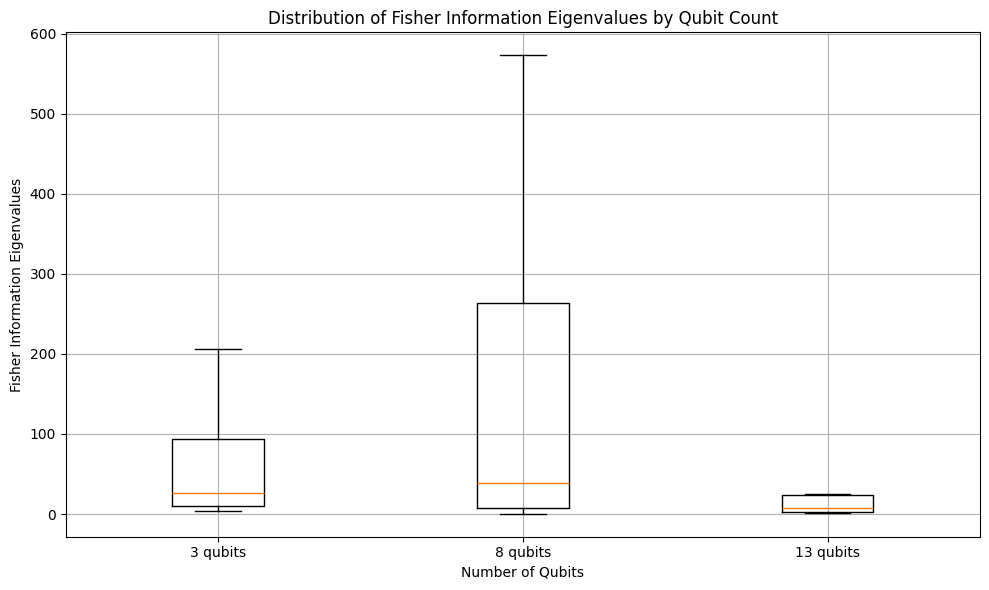

In [13]:
import matplotlib.pyplot as plt

eigenvalue_lists = [result['fisher_eigvals'] for result in results]
qubit_labels = [f"{result['n_qubits']} qubits" for result in results]

plt.figure(figsize=(10, 6))
plt.boxplot(eigenvalue_lists, labels=qubit_labels, showfliers=False)
plt.xlabel("Number of Qubits")
plt.ylabel("Fisher Information Eigenvalues")
plt.title("Distribution of Fisher Information Eigenvalues by Qubit Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
eight_qubits_eigvals = np.array(eigenvalue_lists[0])
eleven_qubits_eigvals = np.array(eigenvalue_lists[1])
fourteen_qubits_eigvals = np.array(eigenvalue_lists[2])

In [15]:
from statsmodels import robust

print(f'MEDIAN = {np.median(eight_qubits_eigvals)}, MAD = {robust.mad(eight_qubits_eigvals)}')
print(f'MEDIAN = {np.median(eleven_qubits_eigvals)}, MAD = {robust.mad(eleven_qubits_eigvals)}')
print(f'MEDIAN = {np.median(fourteen_qubits_eigvals)}, MAD = {robust.mad(fourteen_qubits_eigvals)}')

MEDIAN = 25.944435119628906, MAD = 30.540012072369727
MEDIAN = 38.81881332397461, MAD = 52.646111805099686
MEDIAN = 7.930367469787598, MAD = 8.821627313869396
